_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Student name: FILL IN YOUR NAMES HERE

# Coding Lab 3

- __Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `scipy.signal.decimate`.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-05-15 10:51:25W. Europe Daylight Time

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.4.0

sklearn: 1.1.1

matplotlib: 3.5.2
pandas    : 1.4.3
scipy     : 1.8.1
seaborn   : 0.11.2
numpy     : 1.23.0

Watermark: 2.4.3



In [5]:
plt.style.use(
    "D:/qds lectures/sem4/Neural Data Science/Assignments/1/CL1/matplotlib_style.txt"
)

## Load data

In [58]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv(
    "D:/qds lectures/sem4/Neural Data Science/Assignments/3/nds_cl_3_ogb_calcium.csv",
    header=0,
)
ogb_spikes = pd.read_csv(
    "D:/qds lectures/sem4/Neural Data Science/Assignments/3/nds_cl_3_ogb_spikes.csv",
    header=0,
)

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv(
    "D:/qds lectures/sem4/Neural Data Science/Assignments/3/nds_cl_3_gcamp2_calcium.csv",
    header=0,
)
gcamp_spikes = pd.read_csv(
    "D:/qds lectures/sem4/Neural Data Science/Assignments/3/nds_cl_3_gcamp2_spikes.csv",
    header=0,
)

In [59]:
ogb_calcium.shape, ogb_spikes.shape, gcamp_calcium.shape, gcamp_spikes.shape

((71986, 11), (71986, 11), (23973, 37), (23973, 37))

In [60]:
ogb_spikes.head()  # 1 if spike - 100 cells view
ogb_calcium.head()  # calcium traces - 100 cells view
gcamp_calcium.head()  # calcium traces - individual cell zoom
gcamp_spikes.head()  # 1 if spike - individual cell zoom

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

Comment for task 1: I have included 10-20s for the plot because they asked us to zoom in on small segment. please feel free to try variations to show spike and ca trace are related

C:\Users\Lalitha Sivakumar\AppData\Local\Temp\ipykernel_9800\1470089359.py:71: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


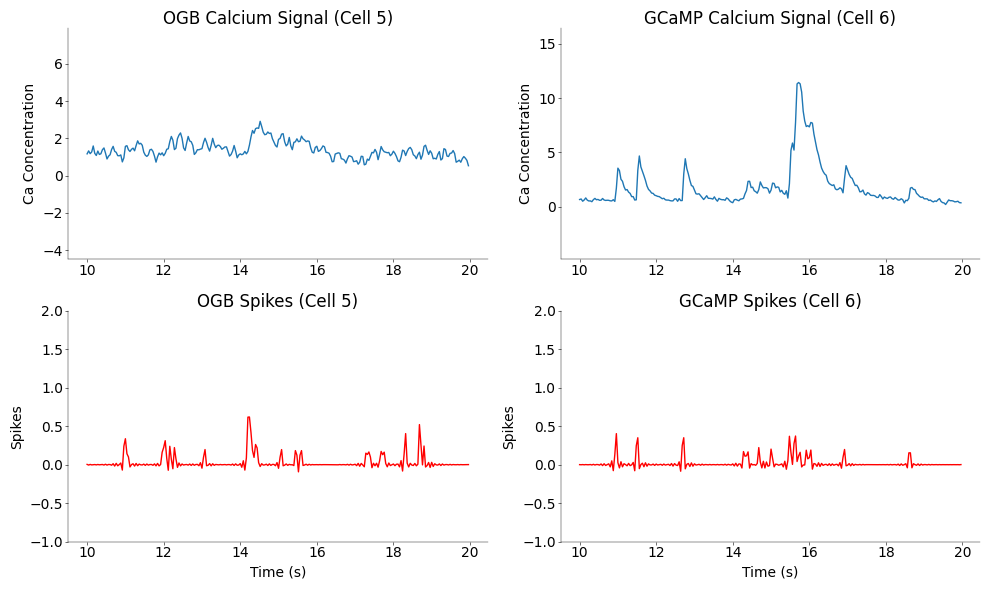

In [61]:
from scipy.signal import decimate  # resample data to 25 Hz


def decimate_dataframe(df, factor):
    return df.apply(lambda x: decimate(x, factor), axis=0)


factor = 4  # decimate factor from 100 Hz to 25 Hz

ogb_calcium_resampled = decimate_dataframe(ogb_calcium, factor)  # resample all signals
ogb_spikes_resampled = decimate_dataframe(ogb_spikes, factor)
gcamp_calcium_resampled = decimate_dataframe(gcamp_calcium, factor)
gcamp_spikes_resampled = decimate_dataframe(gcamp_spikes, factor)

ogb_cell = 5  # example cells to plot
gcamp_cell = 6

t_beg = 10
t_end = 20
srate = 25

start_index = int(t_beg * srate)
end_index = int(t_end * srate)

ogb_calcium_trace = ogb_calcium_resampled.iloc[
    start_index:end_index, ogb_cell
]  # zoom into 10-20s
ogb_spikes_trace = ogb_spikes_resampled.iloc[start_index:end_index, ogb_cell]
gcamp_calcium_trace = gcamp_calcium_resampled.iloc[start_index:end_index, gcamp_cell]
gcamp_spikes_trace = gcamp_spikes_resampled.iloc[start_index:end_index, gcamp_cell]

time_vector = np.arange(t_beg, t_end, 1 / srate)
time_vector = time_vector[: len(ogb_calcium_trace)]  # ensure match

# ----------------------------
# Plot raw calcium data (1 pt)
# ----------------------------
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# plot ogb
axs[0, 0].plot(time_vector, ogb_calcium_trace, label="OGB Calcium")  # ogb
axs[0, 1].plot(time_vector, gcamp_calcium_trace, label="GCaMP Calcium")  # gcamp
axs[0, 0].set_title("OGB Calcium Signal (Cell 5)")
axs[0, 1].set_title("GCaMP Calcium Signal (Cell 6)")
axs[0, 0].set_ylabel("Ca Concentration")
axs[0, 1].set_ylabel("Ca Concentration")
axs[1, 0].set_ylabel("Spikes")
axs[1, 0].set_xlabel("Time (s)")

# --------------------------
# Plot raw spike data (1 pt)
# --------------------------

axs[1, 0].plot(time_vector, ogb_spikes_trace, label="OGB Spikes", color="r")
axs[1, 1].plot(time_vector, gcamp_spikes_trace, label="GCaMP Spikes", color="r")
axs[1, 0].set_title("OGB Spikes (Cell 5)")
axs[1, 1].set_title("GCaMP Spikes (Cell 6)")
axs[1, 0].set_ylabel("Spikes")
axs[1, 1].set_ylabel("Spikes")
axs[1, 1].set_xlabel("Time (s)")


offset = 5  # offset
axs[0, 0].set_ylim([ogb_calcium_trace.min() - offset, ogb_calcium_trace.max() + offset])
axs[0, 1].set_ylim(
    [gcamp_calcium_trace.min() - offset, gcamp_calcium_trace.max() + offset]
)
axs[1, 0].set_ylim([-1, 2])
axs[1, 1].set_ylim([-1, 2])

plt.tight_layout()
plt.show()

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this.

*Grading: 3 pts*


Comment for Task 2: 

1) in the function definition, for deconvolution i have used signal.deconvolve. there's also a commented out section where i have tried to use lfilter which is also a similar function to sort of filter in 1d. Please decide which one to use and delete the unnecessary part.
2) deconvolved plot stops after some seconds

In [62]:
# from scipy.signal import lfilter


def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
    """

    # insert your code here
    klen = int(10 * tau / dt)  # kernel length in with respect to time steps
    kernel = np.exp(-np.arange(0, klen * dt, dt) / tau)

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # sp_hat = lfilter([1], kernel, ca)
    # sp_hat[sp_hat < 0] = 0  #filter out negatives

    sp_hat, _ = signal.deconvolve(ca, kernel)
    # --------------------------------------------

    return sp_hat

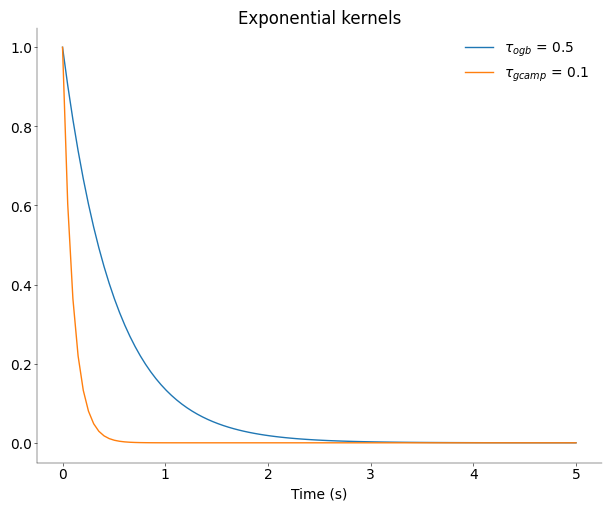

In [69]:
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")

# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------
tau_ogb = 0.5
tau_gcamp = 0.1

X = np.linspace(0, 5, 100)

y_ogb = np.exp(-1 * X / tau_ogb)
y_gcamp = np.exp(-1 * X / tau_gcamp)

ax.plot(X, y_ogb, label=f"$\\tau_{{ogb}}$ = {tau_ogb}")
ax.plot(X, y_gcamp, label=f"$\\tau_{{gcamp}}$ = {tau_gcamp}")
ax.set_xlabel("Time (s)")
ax.set_title("Exponential kernels")
ax.legend()

Text(0.5, 0, 'Time (s)')

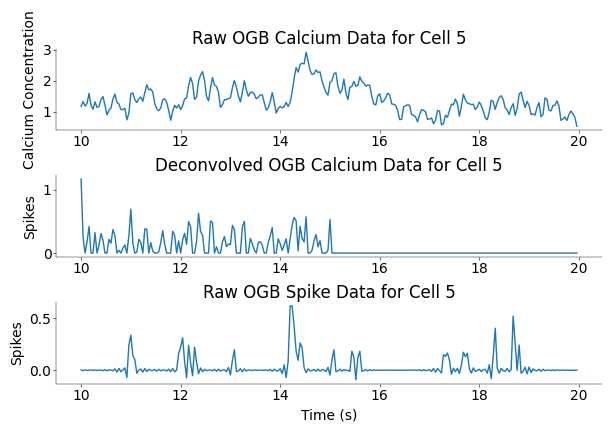

In [85]:
# --------------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB or GCamP Cell (1 pt)
# --------------------------------------------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(6, 4), gridspec_kw=dict(hspace=0))

ogb_cell = 5  # example cells to plot
gcamp_cell = 6
t_beg = 10
t_end = 20
srate = 25
start_index = int(t_beg * srate)
end_index = int(t_end * srate)
dt = 1 / srate
time_vector = np.arange(t_beg, t_end, dt)

ogb_calcium_re_deconv = np.maximum(
    0,
    deconv_ca(
        ogb_calcium_resampled.iloc[start_index:end_index, ogb_cell].values, tau_ogb, dt
    ),
)
gcamp_calcium_re_deconv = np.maximum(
    0,
    deconv_ca(
        gcamp_calcium_resampled.iloc[start_index:end_index, gcamp_cell].values,
        tau_gcamp,
        dt,
    ),
)

# Ensure ogb_calcium_re_deconv has the correct length (250)
if len(ogb_calcium_re_deconv) < len(time_vector):
    ogb_calcium_re_deconv = np.concatenate(
        [ogb_calcium_re_deconv, np.zeros(len(time_vector) - len(ogb_calcium_re_deconv))]
    )

# plot ogb data
axs[0].plot(time_vector, ogb_calcium_resampled.iloc[start_index:end_index, ogb_cell])
axs[0].set_title("Raw OGB Calcium Data for Cell 5")
axs[0].set_ylabel("Calcium Concentration")

axs[1].plot(time_vector, ogb_calcium_re_deconv)
axs[1].set_title("Deconvolved OGB Calcium Data for Cell 5")
axs[1].set_ylabel("Spikes")

axs[2].plot(time_vector, ogb_spikes_resampled.iloc[start_index:end_index, ogb_cell])
axs[2].set_title("Raw OGB Spike Data for Cell 5")
axs[2].set_ylabel("Spikes")
axs[2].set_xlabel("Time (s)")

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 2 pts*



In [53]:
# run this cell to download the oopsi.py file if you haven't already mannually downloaded it
# and put it in the same folder as this notebook
!curl https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py > oopsi.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  7973  100  7973    0     0  26140      0 --:--:-- --:--:-- --:--:-- 26226


In [54]:
import oopsi

In [65]:
# --------------------------------------------------------------
# Apply one of the advanced algorithms on the OGB Cell (0.5 pts)

hz = 25
dt = 1 / hz

n_best, C_best = oopsi.fast(ogb_calcium_re[:, idx_ogb], dt=dt, iter_max=10)
# --------------------------------------------------------------

InvalidIndexError: (slice(None, None, None), 4)

In [ ]:
# -------------------------------------------
# Plot the results for the OGB Cell (0.5 pts)
# -------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

In [ ]:
# ----------------------------------------------------------------
# Apply one of the advanced algorithms on the GCamP Cell (0.5 pts)
# ----------------------------------------------------------------

In [ ]:
# ---------------------------------------------
# Plot the results for the GCamp Cell (0.5 pts)
# ---------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)


# GCamP Cell

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


Evaluate on OGB data

In [ ]:
# -------------------------------------------------
# Create dataframe for OGB Cell as described (1 pt)
# -------------------------------------------------

Create OGB dataframe

In [ ]:
df_ogb = pd.DataFrame({"algorithm": algo, "correlation": c, "indicator": indicator})
df_ogb.head()

Evaluate on GCamp data

In [ ]:
# ---------------------------------------------------
# Create dataframe for GCamP Cell as described (1 pt)
# ---------------------------------------------------

Create GCamp dataframe

In [ ]:
df_gcamp = pd.DataFrame({"algorithm": algo, "correlation": c, "indicator": indicator})
df_gcamp.head()

Combine both dataframes and plot

In [ ]:
# ---------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described (1 pt)
# hint: you can seperate the algorithms by color
# ---------------------------------------------------------------------------